# 1. Import and setup

In [156]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as scstat
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import pearsonr, ttest_ind
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [157]:
# Setting up styling
sns.set(style="darkgrid")
sns.set_palette("flare")

print(sns.color_palette("flare").as_hex())
palette = sns.color_palette("flare").as_hex()
sns.color_palette("flare")

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']


[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [158]:
RANDOM_STATE=42

In [159]:
# Helper function

"""
Plots histogram and boxplot to compare difference in distribution of given label
- label: the feature to be compared
- title: title of the figure
"""
def plot_mean_difference(df, label, title, colours, features_kde):
    fig, axes = plt.subplots(2, len(features_kde), figsize=(40, 7))
    value = df[label].unique()
    p_vals = []

    for i in range(len(features_kde)):
        feature = features_kde[i]
        for j, val in enumerate(df[label].unique()):
            sns.kdeplot(df[df[label] == val][feature], ax=axes[0, i], fill=True, label=val, color=colours[j])
        axes[0, i].set(ylabel=None)
        axes[0, i].set(xlabel=None)
        axes[0, i].set_title(feature)

        sns.boxplot(ax=axes[1, i], x=label, y=feature, data=df, palette=colours)
        axes[1, i].set(ylabel=None)
        axes[1, i].set(xlabel=None)
        
        if 'cluster' in label:
            values = [df[df[label] == cluster][feature] for cluster in df[label].unique()]
            statistic, p_value = scstat.f_oneway(*values)
        else:
            statistic, p_value = ttest_ind(df[df[label] == value[0]][feature].dropna(),
                                    df[df[label] == value[1]][feature].dropna())
        p_vals.append(round(p_value,3))
        print(feature, p_value)
    axes[0,-1].legend(title=label)

    fig.suptitle(title)
    plt.show()
    return dict(zip(features_kde, p_vals))

"""
Plot coefficient correlation inside a pair plot, used in pair_plot function
"""
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    marker_size = abs(r) * 10000
    ax.scatter([.5], [.5], marker_size, [r], alpha=0.6, cmap="flare",
            vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

"""
Plot pair grid of bivariate analysis, includes scatter plot and correlation computation
- df: dataframe containing all features
- label: the feature to be compared
- title: title of figure
"""
def pair_plot(df, label, title, colours):
    g = sns.PairGrid(df, hue=label, diag_sharey=False, palette=colours)
    g.map_upper(reg_coef, hue=None)
    g.map_diag(sns.kdeplot, fill=True)
    g.map_lower(sns.scatterplot)

    g.add_legend(adjust_subtitles=True, title=label)
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title)

    plt.show()

# 2. Read dataset

In [160]:
df = pd.read_csv('../dataset/digital_final_27th_Oct.csv', index_col=0)
df.head()

,hadm_id,alcoholism,gender,anchor_age,deathtime,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,22698313,0,F,89,2164-09-06T02:23:00,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0
1,29562026,0,F,84,NaN,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1
2,21607777,0,F,37,NaN,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2
3,25233292,0,M,47,NaN,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4
4,24214772,0,M,22,NaN,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0


In [161]:
# Label mortality
df['mortality'] = df['deathtime'].apply(lambda x: 'Survive' if x is np.nan else 'Dead')
df['mortality'].value_counts()

mortality
Survive    249
Dead        62
Name: count, dtype: int64

In [162]:
df.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime',
       'hematocrit_serum', 'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

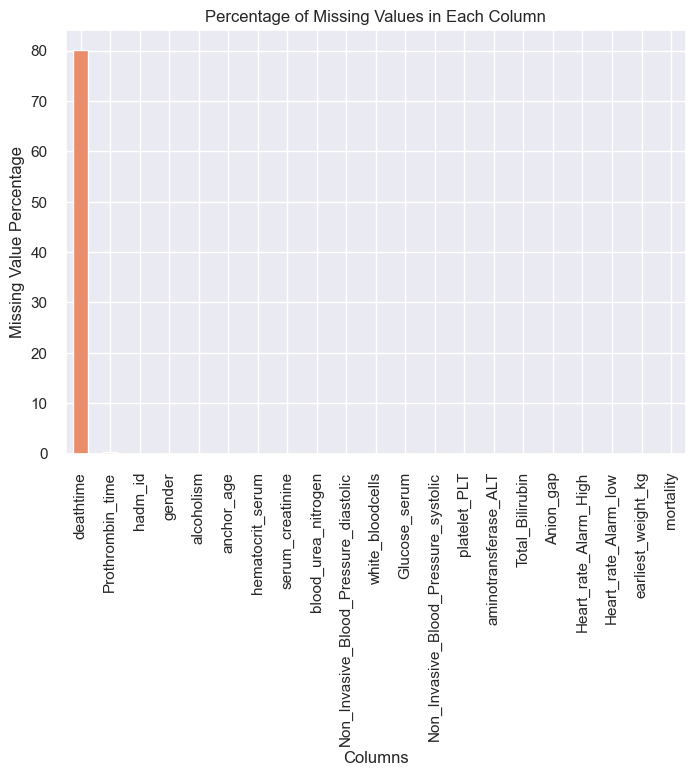

In [163]:
# Datatype and missing value information
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
    
missing_percentage.sort_values(ascending=False).plot(kind='bar', color=palette[0])
plt.xlabel('Columns')
plt.ylabel('Missing Value Percentage')
plt.title('Percentage of Missing Values in Each Column')
plt.show()

In [164]:
missing_columns = missing_percentage.sort_values(ascending=False)[:1]
missing_columns

deathtime    80.064309
dtype: float64

In [165]:
df_clean = df.drop(missing_columns.index, axis=1)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality
0,22698313,0,F,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0,Dead
1,29562026,0,F,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1,Survive
2,21607777,0,F,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2,Survive
3,25233292,0,M,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4,Survive
4,24214772,0,M,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0,Survive


In [166]:
(df_clean.isnull().sum(axis=1) / df_clean.shape[1]).value_counts().sort_index()

0.00    310
0.05      1
Name: count, dtype: int64

In [167]:
# Statistical description of numerical features
df_clean.describe(include=[np.number]).round(2)

,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,310.00,311.00,311.00,311.00,311.00,311.00,311.00
mean,24968797.93,0.13,59.98,32.45,31.84,1.81,123.07,70.53,13.82,152.17,221.18,17.75,195.26,2.76,15.94,125.37,52.75,80.41
std,2848398.04,0.34,17.64,7.46,27.77,1.89,27.23,19.79,11.79,92.15,142.87,10.48,641.63,5.56,5.38,10.08,5.98,22.56
min,20009550.00,0.00,22.00,16.60,1.00,0.10,57.00,25.00,0.20,36.00,6.00,8.80,2.00,0.00,5.00,100.00,40.00,32.00
25%,22547487.50,0.00,48.00,27.30,14.00,0.80,103.00,56.00,7.20,103.00,117.50,13.40,18.00,0.50,13.00,120.00,50.00,64.95
50%,24961541.00,0.00,61.00,31.40,23.00,1.10,121.00,68.00,11.30,133.00,198.00,15.40,35.00,1.00,15.00,120.00,50.00,78.00
75%,27380606.50,0.00,73.00,37.10,40.50,2.10,140.50,83.00,17.60,168.00,290.00,18.58,106.00,2.50,18.00,130.00,60.00,93.00
max,29995505.00,1.00,91.00,54.30,163.00,20.40,259.00,142.00,156.20,817.00,942.00,150.00,8805.00,53.10,44.00,170.00,90.00,166.60


In [168]:
# Statistical description of categorical features
df_clean.describe(include=[np.object_])

,gender,mortality
count,311,311
unique,2,2
top,M,Survive
freq,163,249


In [169]:
# Number of distinct patients
print('Number of distinct patients: ', df_clean.hadm_id.unique().shape[0])
print('Number of duplication', len(df_clean[df_clean.duplicated()]))

Number of distinct patients:  311
Number of duplication 0


In [170]:
df_clean.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

In [171]:
features_kde = ['hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg']

# 4. Preprocessing

In [172]:
# Drop gender
X = df_clean.drop(['hadm_id', 'gender'], axis=1)
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality
0,0,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0,Dead
1,0,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1,Survive
2,0,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2,Survive
3,0,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4,Survive
4,0,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0,Survive


In [173]:
X['gender'] = LabelEncoder().fit_transform(df_clean['gender'])
X['mortality'] = LabelEncoder().fit_transform(df_clean['mortality'])
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality,gender
0,0,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0,0,0
1,0,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1,1,0
2,0,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2,1,0
3,0,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4,1,1
4,0,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0,1,1


In [174]:
X = X.fillna(X.median())

In [175]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.38418938,  1.6476941 , -1.68594643, ..., -1.08353743,
        -2.0040282 , -1.04945288],
       [-0.38418938,  1.36382923, -1.33676957, ..., -0.10244702,
         0.49899497, -1.04945288],
       [-0.38418938, -1.30450056, -0.39667804, ..., -1.25223171,
         0.49899497, -1.04945288],
       ...,
       [-0.38418938,  0.05805082,  0.00621834, ..., -0.09356837,
        -2.0040282 ,  0.95287746],
       [-0.38418938,  1.30705625, -0.0340713 , ..., -1.17232389,
         0.49899497, -1.04945288],
       [-0.38418938, -0.56645189, -1.04131223, ...,  0.03073268,
         0.49899497,  0.95287746]])

One of the feature of standard scaling is that, we can detect outliers by filtering values `abs(x) > 3.5`. We choose number `3.5` as it does not discard huge amount of data while still being reasonable number for an outlier.

In [176]:
# Outliers detection for each features
X_cleaned = pd.DataFrame(X_scaled)
X_cleaned = X_scaled[(np.abs(X_scaled) < 3.5).all(axis=1)]
df_clean = df_clean[(np.abs(X_scaled) < 3.5).all(axis=1)].reset_index(drop=True)
X = X[(np.abs(X_scaled) < 3.5).all(axis=1)]
print("Number of cleaned record is", len(X_cleaned))
X_cleaned

Number of cleaned record is 277


array([[-0.38418938,  1.6476941 , -1.68594643, ..., -1.08353743,
        -2.0040282 , -1.04945288],
       [-0.38418938,  1.36382923, -1.33676957, ..., -0.10244702,
         0.49899497, -1.04945288],
       [-0.38418938, -1.30450056, -0.39667804, ..., -1.25223171,
         0.49899497, -1.04945288],
       ...,
       [ 2.60288302, -1.53159245,  0.77172144, ...,  0.11507982,
         0.49899497,  0.95287746],
       [-0.38418938,  0.22836975, -0.18179997, ...,  0.43027176,
         0.49899497,  0.95287746],
       [-0.38418938,  1.30705625, -0.0340713 , ..., -1.17232389,
         0.49899497, -1.04945288]])

In [177]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_cleaned)

# Create a DataFrame for visualization
X_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
X_pca

,PC1,PC2,PC3
0,-2.450041,0.980380,-1.978989
1,-0.565437,-0.699496,-0.561575
2,-1.555885,-0.968665,0.253054
3,0.708821,3.375716,0.222916
4,2.330734,-0.143030,0.008252
...,...,...,...
272,-1.333672,1.051397,-0.493342
273,1.185549,-1.161565,-1.100051
274,2.142093,0.258664,2.627356
275,0.506146,2.438278,-0.274836


# 5. K-Means


## 5.1. Finding optimal cluster

#### Manual

In [178]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_cleaned)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_cleaned, kmeans.labels_)
    ss.append(sil_score)

In [179]:
total_var = np.sum(np.var(X, axis=0)) * X.shape[0]
total_var

24657354.44974729

In [180]:
var_explained = (1 - (np.array(wcss) / np.sum(wcss))) * 100
var_explained

array([89.92040271, 90.67417078, 91.29146083, 91.78500028, 92.19089696,
       92.41995737, 92.63349033, 92.77004697, 92.95363261, 93.14202411,
       93.277456  , 93.42194819, 93.51951285])

Text(0.5, 1.0, 'Total Variance Explained')

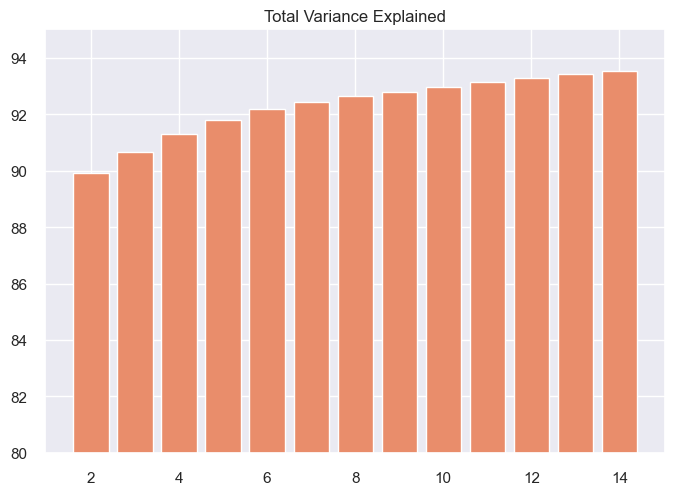

In [181]:
plt.bar(range(2,15), var_explained)
plt.ylim((80,95))
plt.title("Total Variance Explained")

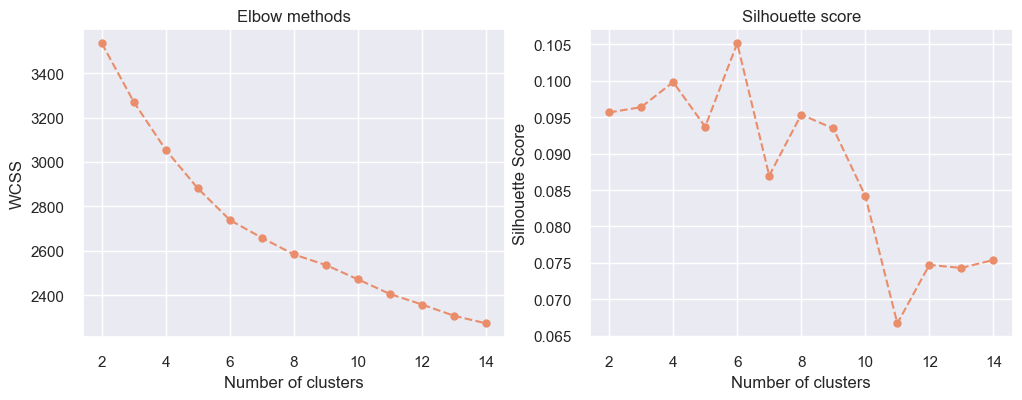

In [182]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.show()

#### On Yellowbrick

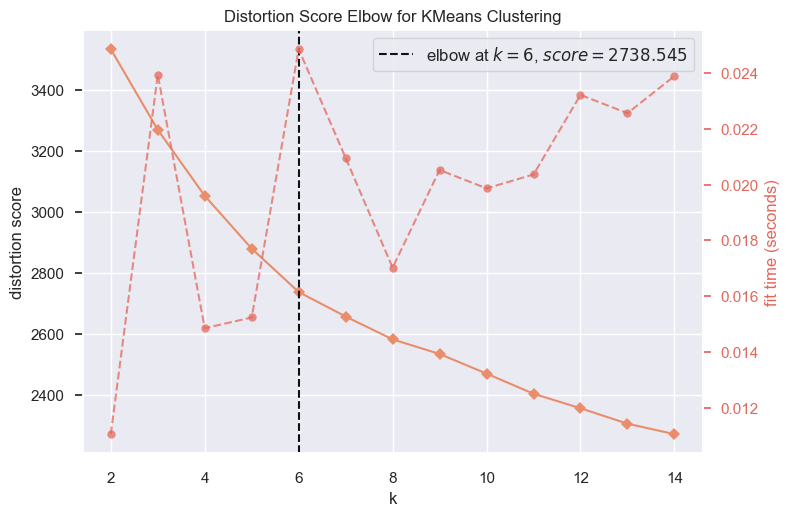

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [183]:
model = KMeans(random_state=RANDOM_STATE)
visualizer = KElbowVisualizer(model, k=(2,15))
# Fit and show the performance with dataset
visualizer.fit(X_cleaned)
visualizer.show()

In [184]:
kmeans_cluster = 6

## 5.2. Fitting the model

In [185]:
# Fit model
kmeans = KMeans(n_clusters=kmeans_cluster, random_state=RANDOM_STATE)
kmeans.fit(X_cleaned)

df_clean['cluster'] = kmeans.labels_.astype(object)
X_pca['cluster'] = df_clean['cluster']
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality,cluster
0,22698313,0,F,89,19.9,40.0,1.0,107.0,54.0,39.7,...,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0,Dead,1
1,29562026,0,F,84,22.5,26.0,0.7,118.0,96.0,7.1,...,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1,Survive,5
2,21607777,0,F,37,29.5,31.0,2.0,76.0,48.0,18.6,...,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2,Survive,5
3,25233292,0,M,47,29.9,97.0,6.8,137.0,85.0,9.7,...,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4,Survive,3
4,24214772,0,M,22,43.0,11.0,0.9,148.0,80.0,18.1,...,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0,Survive,0


In [186]:
# Evaluation metric
wcss = kmeans.inertia_
ss = silhouette_score(X_cleaned, kmeans.labels_)

print(f"Fitting model with {kmeans_cluster} clusters, resulting on {round(wcss,2)} WCSS and {round(ss,2)} silhouette score")

Fitting model with 6 clusters, resulting on 2738.54 WCSS and 0.11 silhouette score


In [187]:
# Center of clusters
kmeans_center = scaler.inverse_transform(kmeans.cluster_centers_)
pd.DataFrame(dict(zip(df_clean.columns, kmeans_center.T)))

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,4.651163e-02,59.348837,41.297674,26.302326,1.379070,153.418605,92.279070,14.148837,167.046512,214.186047,16.646512,131.093023,1.974419,15.720930,127.325581,53.023256,88.444186,7.906977e-01,0.813953
1,2.775558e-17,71.142857,29.082857,33.914286,1.688571,111.514286,58.685714,15.808571,135.371429,227.457143,17.325714,136.228571,2.314286,15.400000,125.285714,51.142857,77.840000,-2.220446e-16,0.485714
2,1.000000e+00,46.387097,33.212903,22.870968,1.422581,120.612903,75.193548,10.835484,146.612903,133.193548,17.148387,118.032258,4.335484,16.451613,126.774194,54.193548,81.377419,9.354839e-01,0.612903
3,5.000000e-02,56.600000,27.960000,84.100000,5.200000,129.150000,73.550000,13.705000,127.350000,162.050000,20.735000,112.000000,3.650000,20.500000,122.500000,51.000000,76.245000,8.000000e-01,0.450000
4,2.775558e-17,65.161290,31.079032,29.241935,1.574194,109.338710,61.306452,12.506452,148.870968,232.000000,16.654839,112.016129,1.696774,14.161290,123.548387,52.338710,92.609677,1.000000e+00,0.967742
5,2.775558e-17,59.697674,31.501163,17.755814,1.059302,120.220930,68.267442,12.577907,132.906977,243.093023,15.358140,124.476744,1.791860,14.348837,124.302326,53.023256,65.660465,1.000000e+00,0.023256


# 5. DBSCAN

In [188]:
# Applying DBScan
dbscan = DBSCAN(eps=3)
clusters = dbscan.fit_predict(X_cleaned)

df_clean['DB_cluster'] = clusters
X_pca['DB_cluster'] = clusters
df_clean['DB_cluster'].value_counts()

DB_cluster
 0    162
-1     97
 1     18
Name: count, dtype: int64

In [189]:
db_cluster = 3

In [190]:
silhouette_score(X_cleaned, X_pca['DB_cluster'])

0.07780418166054735

# K-Prototypes

In [191]:
# Drop gender
X2 = df_clean.drop(['hadm_id', 'gender', 'mortality', 'alcoholism', 'cluster', 'DB_cluster'], axis=1)
X2 = X2.fillna(X2.median())
X2.head()

,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0
1,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1
2,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2
3,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4
4,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0


In [192]:
scaler2 = StandardScaler()
X_scaled2 = scaler2.fit_transform(X2)
X_scaled2

array([[ 1.61182812, -1.72373231,  0.46604499, ...,  0.53251352,
        -2.23506412, -1.08963869],
       [ 1.32806278, -1.36966466, -0.13023428, ..., -0.50626285,
        -0.46363991, -0.05573427],
       [-1.33933144, -0.41640559,  0.0827226 , ...,  2.61006627,
        -2.23506412, -1.26741411],
       ...,
       [-1.56634371,  0.76835926,  0.12531398, ..., -0.50626285,
         1.3077843 ,  0.17350246],
       [ 0.19300141, -0.1985178 ,  2.04192594, ..., -0.50626285,
         1.3077843 ,  0.5056618 ],
       [ 1.27130971, -0.04871995, -0.68392218, ..., -0.50626285,
        -0.46363991, -1.1832047 ]])

In [193]:
X_scaled2 = np.c_[X_scaled2, X['gender'], X['alcoholism'], X['mortality']]

In [194]:
costs = []
n_clusters = []
ss = []

for i in range(2, 15):
    kproto = KPrototypes(n_clusters=i, random_state=RANDOM_STATE)
    clusters = kproto.fit_predict(X_scaled2, categorical=[16,17,18])
    
    costs.append(kproto.cost_)
    n_clusters.append(i)

    # Record silhouette score
    sil_score = silhouette_score(X_scaled2, clusters)
    ss.append(sil_score)

In [239]:
(1 - (np.array(costs) / np.sum(costs))) * 100

array([90.01308337, 90.78135963, 91.29447739, 91.74565254, 92.02032089,
       92.32143627, 92.51669429, 92.83529994, 92.95033795, 93.13388815,
       93.32082815, 93.46900587, 93.59761555])

Text(0.5, 1.0, 'Total Variance Explained')

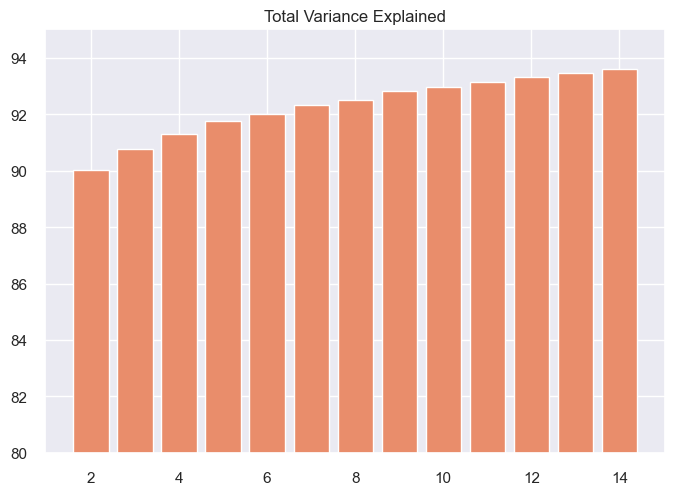

In [195]:
plt.bar(range(2,15), (1 - (np.array(costs) / np.sum(costs))) * 100)
plt.ylim((80,95))
plt.title("Total Variance Explained")

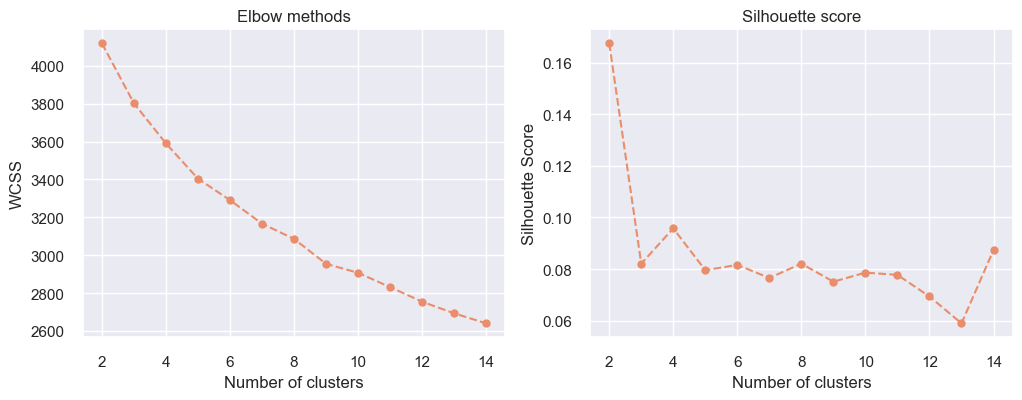

In [196]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), costs, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.show()

In [197]:
proto_cluster = 4

In [210]:
costs[2]

3589.732053421392

In [211]:
ss

[0.1674864466578839,
 0.08209673708320654,
 0.09577150858453644,
 0.07957525980790775,
 0.08161352447950053,
 0.07657752446442284,
 0.08210512009081744,
 0.0751149618508711,
 0.07862769916370442,
 0.07776434048646794,
 0.06938067149309,
 0.05895230051212985,
 0.08734415067047395]

In [212]:
kproto = KPrototypes(n_clusters=proto_cluster, random_state=RANDOM_STATE)
df_clean['proto_cluster'] = kproto.fit_predict(X_scaled2, categorical=[16,17,18])
X_pca['proto_cluster'] = df_clean['proto_cluster']

In [213]:
kproto._enc_cluster_centroids[1]

array([[1, 0, 1],
       [1, 0, 1],
       [0, 0, 1],
       [1, 0, 1]], dtype=object)

In [214]:
scaler2.inverse_transform(kproto._enc_cluster_centroids[0])

array([[6.08555556e+01, 3.85766667e+01, 2.41333333e+01, 1.23777778e+00,
        1.38644444e+02, 8.15000000e+01, 1.66566667e+01, 1.72233333e+02,
        2.91688889e+02, 1.50422222e+01, 1.09788889e+02, 1.46666667e+00,
        1.60000000e+01, 1.26166667e+02, 5.33333333e+01, 8.64344444e+01],
       [4.98888889e+01, 3.20222222e+01, 3.48888889e+01, 2.00000000e+00,
        1.20555556e+02, 6.93333333e+01, 1.27222222e+01, 1.30333333e+02,
        1.88111111e+02, 2.05333333e+01, 1.28377778e+03, 6.28888889e+00,
        1.94444444e+01, 1.30555556e+02, 4.94444444e+01, 8.57555556e+01],
       [5.97862595e+01, 2.97595420e+01, 1.92977099e+01, 1.03358779e+00,
        1.12893130e+02, 6.51068702e+01, 9.81832061e+00, 1.25114504e+02,
        1.82877863e+02, 1.62835878e+01, 7.65267176e+01, 2.31984733e+00,
        1.34580153e+01, 1.23740458e+02, 5.27480916e+01, 7.36458015e+01],
       [6.44255319e+01, 2.89340426e+01, 6.45744681e+01, 4.05106383e+00,
        1.18893617e+02, 6.40000000e+01, 1.55106383e+01, 1.406

In [215]:
pd.DataFrame(np.c_[scaler2.inverse_transform(kproto._enc_cluster_centroids[0]), kproto._enc_cluster_centroids[1]],
            columns=list(X2.columns)+['gender', 'alcoholism', 'mortality'])

,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,gender,alcoholism,mortality
0,60.855556,38.576667,24.133333,1.237778,138.644444,81.5,16.656667,172.233333,291.688889,15.042222,109.788889,1.466667,16.0,126.166667,53.333333,86.434444,1,0,1
1,49.888889,32.022222,34.888889,2.0,120.555556,69.333333,12.722222,130.333333,188.111111,20.533333,1283.777778,6.288889,19.444444,130.555556,49.444444,85.755556,1,0,1
2,59.78626,29.759542,19.29771,1.033588,112.89313,65.10687,9.818321,125.114504,182.877863,16.283588,76.526718,2.319847,13.458015,123.740458,52.748092,73.645802,0,0,1
3,64.425532,28.934043,64.574468,4.051064,118.893617,64.0,15.510638,140.617021,168.702128,20.210638,53.06383,2.980851,18.489362,124.468085,51.489362,80.110638,1,0,1


# Result

In [234]:
def stat_cum(cluster, clusters):
    cluster0 = df_clean[clusters == cluster]
    mort_rate = round(100* len(cluster0[cluster0.mortality == 'Dead']) / len(cluster0),2)
    print(f"Percentage of women and men (respectively) {round(100 * sum(cluster0.gender == 'F') / len(cluster0),2)} and {round(100 * sum(cluster0.gender == 'M') / len(cluster0),2)}")
    print(f"Percentage of alcoholism (respectively) {round(100 * sum(cluster0.alcoholism == 1) / len(cluster0),2)} and {round(100 * sum(cluster0.alcoholism == 0) / len(cluster0),2)}")
    print(f"Mortality rate is {mort_rate}")
    display(round(cluster0.describe(),2))
    return cluster0.describe().loc['mean',:], mort_rate

## Value Counts

In [217]:
df_clean['cluster'].value_counts()

cluster
5    86
4    62
0    43
1    35
2    31
3    20
Name: count, dtype: int64

In [218]:
df_clean['DB_cluster'].value_counts()

DB_cluster
 0    162
-1     97
 1     18
Name: count, dtype: int64

In [219]:
df_clean['proto_cluster'].value_counts()

proto_cluster
2    131
0     90
3     47
1      9
Name: count, dtype: int64

## Statistics

In [235]:
stats = pd.DataFrame(index=list(df_clean.columns) + ['mortality_rate'],
                     columns=[])

In [236]:
# for i in range(kmeans_cluster):
#     print("====================== Cluster %s =========================" % (i))
#     kmeans_result, mort_rate = stat_cum(i, df_clean.cluster)
#     stats["Kmeans" + str(i)] = 0
#     stats.loc[kmeans_result.index, "Kmeans" + str(i)] = kmeans_result.values
#     stats.loc['mortality_rate', "Kmeans" + str(i)] = mort_rate

In [237]:
for i in range(-1,-1+db_cluster):
    print("====================== Cluster %s =========================" % (i))
    db_result, mort_rate = stat_cum(i, df_clean.DB_cluster)
    stats["DB" + str(i)] = 0
    stats.loc[db_result.index, "DB" + str(i)] = db_result.values
    stats.loc['mortality_rate', "DB" + str(i)] = mort_rate

====================== Cluster -1 =========================
Percentage of women and men (respectively) 40.21 and 59.79
Percentage of alcoholism (respectively) 16.49 and 83.51
Mortality rate is 39.18


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.0,97.00
mean,25024396.77,0.16,55.51,31.60,41.55,2.46,125.19,73.91,15.10,154.09,233.88,18.09,189.72,3.14,17.40,128.87,51.91,84.21,-1.0,1.53
std,2919795.38,0.37,19.44,7.54,31.28,1.93,32.77,23.88,8.88,86.77,162.05,6.72,386.85,4.74,5.65,12.41,6.75,24.53,0.0,1.29
min,20076204.00,0.00,22.00,16.60,3.00,0.40,57.00,25.00,0.60,45.00,18.00,11.30,2.00,0.00,5.00,100.00,40.00,40.00,-1.0,0.00
25%,22784735.00,0.00,40.00,26.60,19.00,1.00,100.00,55.00,8.00,97.00,103.00,13.80,17.00,0.50,14.00,120.00,50.00,68.80,-1.0,0.00
50%,25090117.00,0.00,56.00,31.00,32.00,1.70,123.00,71.00,13.60,133.00,195.00,16.00,34.00,1.10,16.00,130.00,50.00,78.00,-1.0,2.00
75%,27615389.00,0.00,70.00,36.80,57.00,3.40,150.00,94.00,19.30,179.00,311.00,19.30,98.00,2.90,20.00,130.00,60.00,97.20,-1.0,3.00
max,29742461.00,1.00,91.00,54.30,126.00,7.90,200.00,137.00,48.60,464.00,645.00,49.00,1789.00,21.20,34.00,160.00,70.00,154.50,-1.0,3.00


====================== Cluster 0 =========================
Percentage of women and men (respectively) 54.94 and 45.06
Percentage of alcoholism (respectively) 0.0 and 100.0
Mortality rate is 7.41


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,162.00,162.0,162.00,162.00,162.00,162.00,162.00,162.00,162.00,162.00,162.00,161.00,162.00,162.00,162.00,162.00,162.00,162.00,162.0,162.00
mean,24789726.52,0.0,64.88,33.21,22.56,1.20,121.33,68.17,12.21,135.91,216.87,15.87,90.70,1.64,14.24,122.69,52.84,75.67,0.0,1.45
std,2802034.41,0.0,15.84,7.21,14.40,0.83,22.69,16.94,7.20,49.70,109.13,4.58,134.96,1.81,3.25,7.07,4.92,19.17,0.0,1.02
min,20009550.00,0.0,23.00,16.70,1.00,0.20,64.00,26.00,0.20,58.00,6.00,9.70,4.00,0.00,6.00,100.00,40.00,32.00,0.0,0.00
25%,22478396.25,0.0,56.00,27.95,12.25,0.70,106.00,56.00,7.10,103.25,138.00,13.10,19.00,0.50,12.00,120.00,50.00,62.50,0.0,0.00
50%,24555722.50,0.0,66.00,31.80,20.00,0.95,119.00,66.50,10.50,127.00,206.00,14.90,34.00,0.95,14.00,120.00,50.00,75.05,0.0,2.00
75%,27148444.50,0.0,76.50,37.88,28.00,1.30,136.00,80.00,15.48,160.00,282.25,16.60,98.00,2.22,16.00,120.00,60.00,87.60,0.0,2.00
max,29995505.00,0.0,91.00,53.20,70.00,5.10,201.00,129.00,42.20,424.00,630.00,41.90,879.00,11.50,24.00,150.00,60.00,122.30,0.0,3.00


====================== Cluster 1 =========================
Percentage of women and men (respectively) 38.89 and 61.11
Percentage of alcoholism (respectively) 100.0 and 0.0
Mortality rate is 0.0


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,18.00,18.0,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.0,18.00
mean,25414801.50,1.0,49.56,31.91,20.22,1.27,118.94,71.28,10.31,150.44,111.78,16.47,47.67,3.47,14.00,123.06,54.44,85.37,1.0,1.61
std,2929648.39,0.0,9.84,7.42,11.02,0.96,17.69,14.00,4.75,55.46,42.66,5.03,32.06,3.26,3.51,5.18,5.11,16.28,0.0,0.92
min,20797749.00,1.0,32.00,16.90,5.00,0.40,89.00,47.00,2.90,69.00,47.00,11.00,12.00,0.20,7.00,120.00,50.00,51.90,1.0,0.00
25%,22513932.00,1.0,43.50,25.83,13.00,0.80,107.00,62.75,7.12,109.25,82.50,12.75,22.50,0.92,12.00,120.00,50.00,73.05,1.0,2.00
50%,25732008.50,1.0,50.00,32.25,19.50,1.00,120.50,75.50,10.30,143.50,118.50,14.75,39.00,1.85,14.00,120.00,50.00,88.00,1.0,2.00
75%,27495664.75,1.0,57.50,37.55,22.75,1.30,126.00,81.75,11.80,179.50,133.00,19.42,72.75,5.50,16.00,127.50,60.00,96.95,1.0,2.00
max,29762400.00,1.0,65.00,44.80,46.00,4.60,151.00,95.00,19.30,284.00,215.00,29.20,119.00,11.40,21.00,135.00,60.00,109.00,1.0,3.00


In [238]:
for i in range(proto_cluster):
    print("====================== Cluster %s =========================" % (i))
    proto_result, mort_rate = stat_cum(i, df_clean.proto_cluster)
    stats["Kproto" + str(i)] = 0
    stats.loc[proto_result.index, "Kproto" + str(i)] = proto_result.values
    stats.loc['mortality_rate', "Kproto" + str(i)] = mort_rate

====================== Cluster 0 =========================
Percentage of women and men (respectively) 40.0 and 60.0
Percentage of alcoholism (respectively) 10.0 and 90.0
Mortality rate is 14.44


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,90.00,90.0,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.0
mean,24942119.52,0.1,60.86,38.58,24.13,1.24,138.64,81.50,16.66,172.23,291.69,15.04,109.79,1.47,16.00,126.17,53.33,86.43,-0.34,0.0
std,2752493.67,0.3,16.71,7.25,14.35,0.64,23.48,18.69,7.45,80.76,136.49,3.79,158.77,1.58,3.91,9.92,6.14,20.95,0.56,0.0
min,20084622.00,0.0,22.00,22.50,4.00,0.40,87.00,39.00,3.00,45.00,72.00,9.70,6.00,0.00,5.00,120.00,40.00,49.50,-1.00,0.0
25%,22759746.00,0.0,50.00,33.50,13.00,0.72,123.00,69.25,10.88,118.50,202.00,12.72,20.00,0.50,14.00,120.00,50.00,70.22,-1.00,0.0
50%,24980009.00,0.0,64.00,39.35,22.50,1.10,138.50,82.00,15.60,146.50,266.00,14.20,39.00,0.85,16.00,120.00,50.00,83.00,0.00,0.0
75%,27149010.00,0.0,71.00,43.38,32.00,1.50,154.00,95.00,20.90,191.75,358.00,16.00,103.00,1.70,18.00,130.00,60.00,100.22,0.00,0.0
max,29955825.00,1.0,91.00,54.30,76.00,3.20,201.00,137.00,48.60,464.00,640.00,30.90,833.00,8.00,34.00,160.00,70.00,154.50,1.00,0.0


====================== Cluster 1 =========================
Percentage of women and men (respectively) 33.33 and 66.67
Percentage of alcoholism (respectively) 11.11 and 88.89
Mortality rate is 33.33


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.0,9.0
mean,25680131.22,0.11,49.89,32.02,34.89,2.00,120.56,69.33,12.72,130.33,188.11,20.53,1283.78,6.29,19.44,130.56,49.44,85.76,-1.0,1.0
std,2943851.08,0.33,15.33,4.16,29.67,1.28,49.96,25.87,9.88,70.55,149.20,6.87,349.83,5.44,4.53,8.82,8.82,24.94,0.0,0.0
min,20079585.00,0.00,25.00,26.00,7.00,0.60,60.00,37.00,2.20,57.00,62.00,11.90,836.00,0.50,13.00,120.00,40.00,66.10,-1.0,1.0
25%,24126677.00,0.00,37.00,29.60,19.00,0.90,79.00,51.00,5.90,81.00,85.00,15.70,1098.00,1.60,15.00,130.00,40.00,71.70,-1.0,1.0
50%,26351031.00,0.00,56.00,31.20,26.00,1.80,118.00,56.00,10.40,141.00,135.00,18.00,1173.00,6.00,19.00,130.00,50.00,75.30,-1.0,1.0
75%,27949113.00,0.00,62.00,33.10,37.00,3.40,153.00,88.00,15.60,151.00,227.00,27.00,1597.00,11.20,22.00,130.00,60.00,80.80,-1.0,1.0
max,29550274.00,1.00,68.00,39.30,109.00,3.90,198.00,113.00,33.10,288.00,536.00,31.10,1789.00,13.90,26.00,150.00,60.00,137.00,-1.0,1.0


====================== Cluster 2 =========================
Percentage of women and men (respectively) 57.25 and 42.75
Percentage of alcoholism (respectively) 14.5 and 85.5
Mortality rate is 13.74


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,130.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.0
mean,24970397.62,0.15,59.79,29.76,19.30,1.03,112.89,65.11,9.82,125.11,182.88,16.29,76.53,2.32,13.46,123.74,52.75,73.65,-0.05,2.0
std,2870841.21,0.35,18.30,5.34,11.31,0.62,19.49,15.32,5.65,45.80,107.61,4.15,118.89,3.11,3.69,9.25,5.31,20.66,0.50,0.0
min,20101858.00,0.00,23.00,16.70,1.00,0.20,57.00,26.00,0.20,58.00,6.00,11.20,4.00,0.20,7.00,100.00,40.00,32.00,-1.00,2.0
25%,22501955.00,0.00,46.00,26.55,11.00,0.70,99.50,54.00,5.80,96.00,105.00,13.75,18.00,0.55,11.00,120.00,50.00,58.10,0.00,2.0
50%,24881005.00,0.00,61.00,29.50,17.00,0.90,112.00,64.00,9.00,112.00,168.00,15.40,31.00,1.20,13.00,120.00,50.00,70.50,0.00,2.0
75%,27464702.50,0.00,74.00,32.85,25.00,1.25,126.00,76.00,12.05,147.00,241.00,17.50,87.00,2.55,15.00,130.00,60.00,85.50,0.00,2.0
max,29995505.00,1.00,91.00,47.30,62.00,5.10,159.00,129.00,27.90,424.00,645.00,41.90,879.00,17.80,34.00,160.00,70.00,149.00,1.00,2.0


====================== Cluster 3 =========================
Percentage of women and men (respectively) 44.68 and 55.32
Percentage of alcoholism (respectively) 10.64 and 89.36
Mortality rate is 34.04


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.0
mean,24547544.34,0.11,64.43,28.93,64.57,4.05,118.89,64.00,15.51,140.62,168.70,20.21,53.06,2.98,18.49,124.47,51.49,80.11,-0.68,3.0
std,2983580.91,0.31,17.40,5.73,28.15,1.80,28.70,22.19,9.62,62.63,112.55,8.80,81.34,4.87,5.10,9.96,4.65,19.70,0.52,0.0
min,20009550.00,0.00,23.00,16.60,21.00,1.00,78.00,25.00,4.30,64.00,9.00,11.50,2.00,0.20,11.00,100.00,40.00,40.00,-1.00,3.0
25%,22081342.00,0.00,53.50,25.70,43.00,2.55,97.00,48.50,7.25,96.50,100.00,14.15,15.50,0.40,14.50,120.00,50.00,72.15,-1.00,3.0
50%,24530817.00,0.00,68.00,28.70,64.00,3.80,114.00,57.00,12.40,135.00,134.00,16.30,28.00,1.00,17.00,120.00,50.00,78.00,-1.00,3.0
75%,26846952.00,0.00,76.00,31.30,82.00,5.50,136.00,78.00,20.35,171.50,246.50,24.10,48.50,2.90,21.50,130.00,50.00,93.15,0.00,3.0
max,29829092.00,1.00,91.00,45.00,126.00,7.90,200.00,131.00,42.20,375.00,495.00,49.00,473.00,21.20,33.00,160.00,60.00,125.00,1.00,3.0


In [231]:
stats.round(2)

,DB-1,DB0,DB1,Kproto0,Kproto1,Kproto2,Kproto3
hadm_id,25024396.77,24789726.52,25414801.50,24942119.52,25680131.22,24970397.62,24547544.34
alcoholism,0.16,0.00,1.00,0.10,0.11,0.15,0.11
gender,0.00,0.00,0.00,0.00,0.00,0.00,0.00
anchor_age,55.51,64.88,49.56,60.86,49.89,59.79,64.43
hematocrit_serum,31.60,33.21,31.91,38.58,32.02,29.76,28.93
blood_urea_nitrogen,41.55,22.56,20.22,24.13,34.89,19.30,64.57
serum_creatinine,2.46,1.20,1.27,1.24,2.00,1.03,4.05
Non_Invasive_Blood_Pressure_systolic,125.19,121.33,118.94,138.64,120.56,112.89,118.89
Non_Invasive_Blood_Pressure_diastolic,73.91,68.17,71.28,81.50,69.33,65.11,64.00
white_bloodcells,15.10,12.21,10.31,16.66,12.72,9.82,15.51


## Mean Difference

In [225]:
mean_diff = []

hematocrit_serum 7.883766014918134e-19
blood_urea_nitrogen 4.650412451808248e-37
serum_creatinine 7.76611086810539e-38
Non_Invasive_Blood_Pressure_systolic 2.6057073383372413e-19
Non_Invasive_Blood_Pressure_diastolic 2.35454152005307e-19
white_bloodcells 0.1347691642729439
Glucose_serum 0.07478115910866946
platelet_PLT 0.0006835653351448855
Prothrombin_time nan
aminotransferase_ALT 0.9976666408580699
Total_Bilirubin 0.0012725697775842234
Anion_gap 2.3753986281139144e-07
Heart_rate_Alarm_High 0.24164953369098624
Heart_rate_Alarm_low 0.20329895809539197
earliest_weight_kg 4.583401199873561e-15


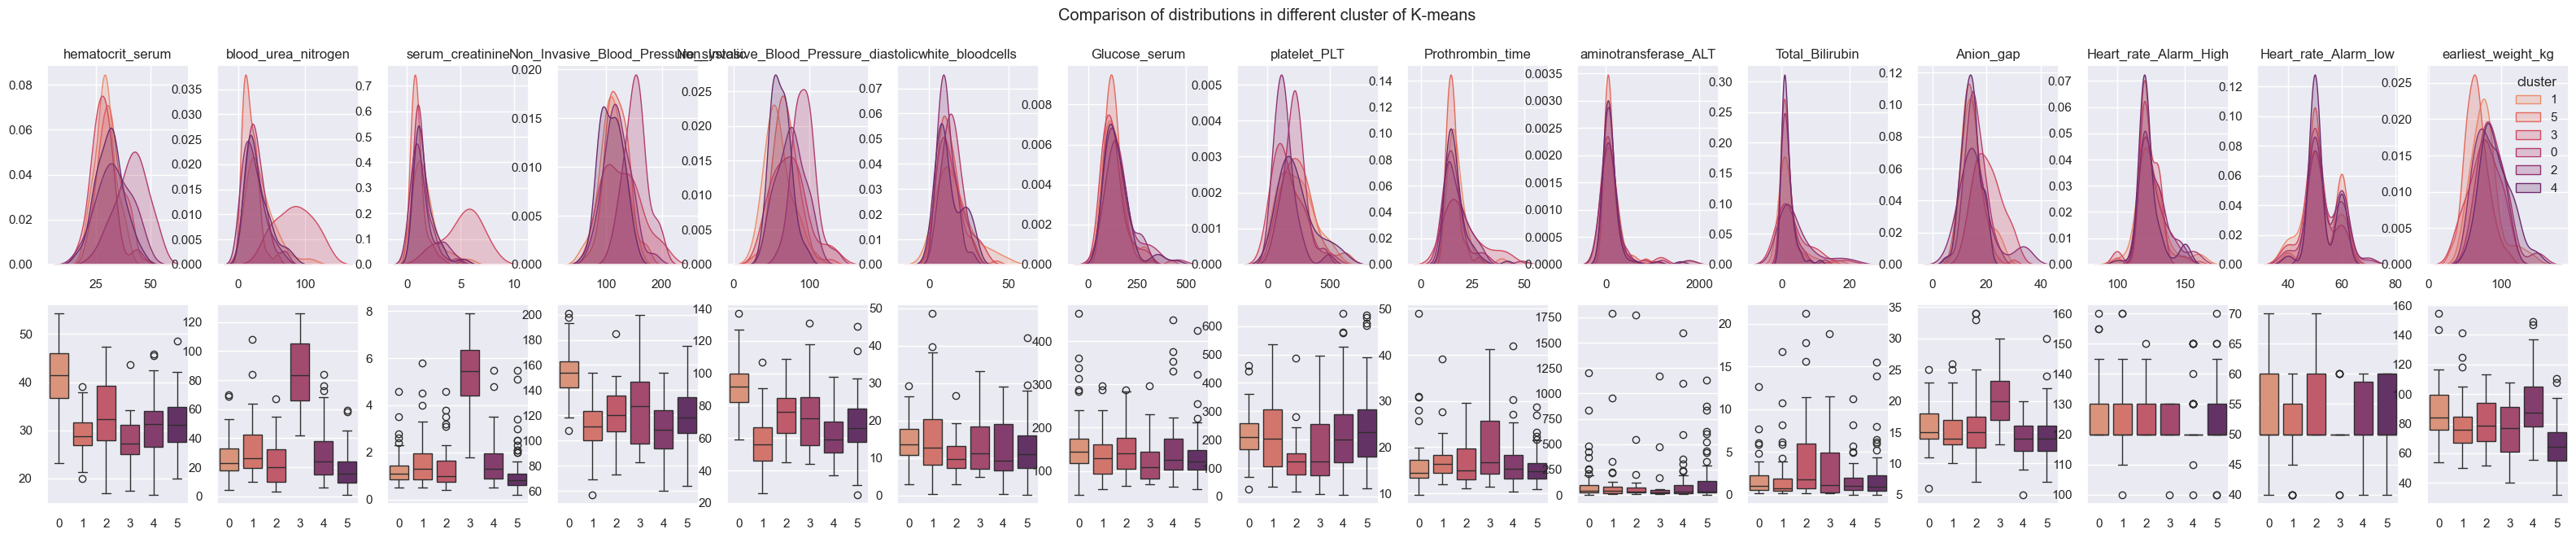

In [226]:
mean_diff.append(plot_mean_difference(df_clean, 'cluster', "Comparison of distributions in different cluster of K-means", colours=palette, features_kde=features_kde))

hematocrit_serum 0.21792737776176818
blood_urea_nitrogen 1.3084861600570214e-10
serum_creatinine 9.73617675307366e-12
Non_Invasive_Blood_Pressure_systolic 0.44079289272557365
Non_Invasive_Blood_Pressure_diastolic 0.07307109740912107
white_bloodcells 0.004532948669655576
Glucose_serum 0.08737220944883754
platelet_PLT 0.0011393854512113017
Prothrombin_time nan
aminotransferase_ALT 0.004289521841259871
Total_Bilirubin 0.0004944831905798651
Anion_gap 6.07116218265967e-08
Heart_rate_Alarm_High 1.6119700946600965e-06
Heart_rate_Alarm_low 0.16074097599823195
earliest_weight_kg 0.0034205176462559694


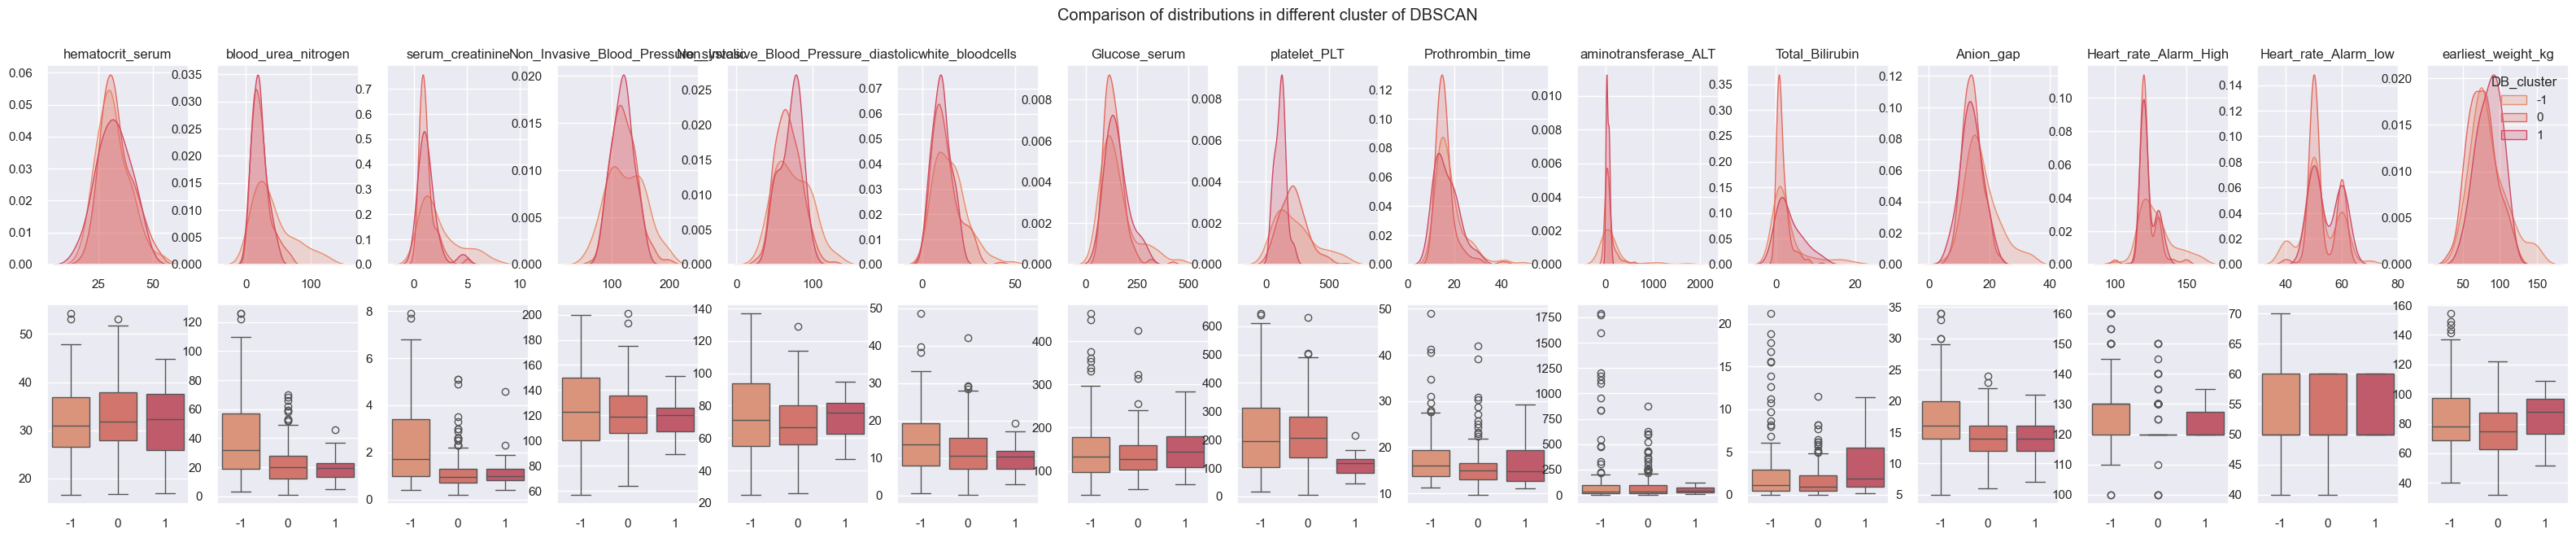

In [227]:
mean_diff.append(plot_mean_difference(df_clean, 'DB_cluster', "Comparison of distributions in different cluster of DBSCAN", colours=palette, features_kde=features_kde))

hematocrit_serum 1.900691760810968e-23
blood_urea_nitrogen 3.0211688957585655e-39
serum_creatinine 1.2753890085073803e-50
Non_Invasive_Blood_Pressure_systolic 2.607694992768038e-12
Non_Invasive_Blood_Pressure_diastolic 3.9620861517633656e-10
white_bloodcells 8.726016466765411e-11
Glucose_serum 2.1314779637636464e-06
platelet_PLT 1.2518099184561362e-10
Prothrombin_time nan
aminotransferase_ALT 1.6442161723019822e-71
Total_Bilirubin 9.000285545988641e-05
Anion_gap 3.602543326483924e-13
Heart_rate_Alarm_High 0.08379570806528791
Heart_rate_Alarm_low 0.10097431002806218
earliest_weight_kg 0.00012853979920425486


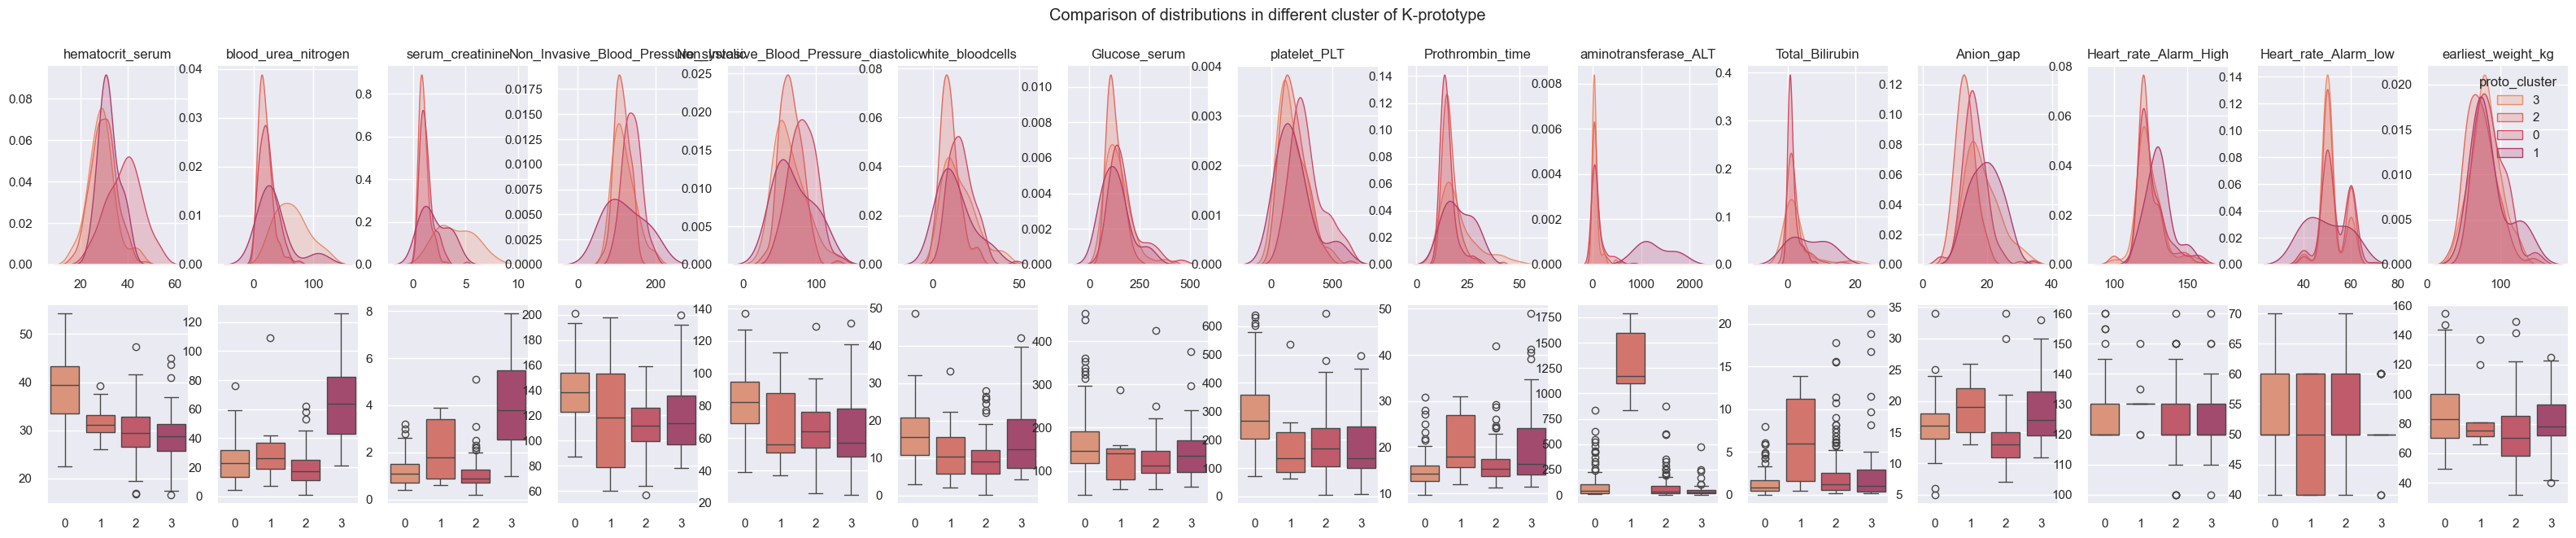

In [228]:
mean_diff.append(plot_mean_difference(df_clean, 'proto_cluster', "Comparison of distributions in different cluster of K-prototype", colours=palette, features_kde=features_kde))

In [229]:
pd.DataFrame(mean_diff).round(3).T

,0,1,2
hematocrit_serum,0.000,0.218,0.000
blood_urea_nitrogen,0.000,0.000,0.000
serum_creatinine,0.000,0.000,0.000
Non_Invasive_Blood_Pressure_systolic,0.000,0.441,0.000
Non_Invasive_Blood_Pressure_diastolic,0.000,0.073,0.000
white_bloodcells,0.135,0.005,0.000
Glucose_serum,0.075,0.087,0.000
platelet_PLT,0.001,0.001,0.000
Prothrombin_time,NaN,NaN,NaN
aminotransferase_ALT,0.998,0.004,0.000


## Mortality rate

In [63]:
def plot_mortality(label):
    mortality_cluster = []
    x_ax = []
    for c in sorted(df_clean[label].unique()):
        sub = df_clean[df_clean[label] == c]
        mortality_cluster.append(100 * len(sub[sub.mortality == 'Dead']) / df_clean.mortality.value_counts()['Dead'])
        x_ax.append(c)

    plt.bar(x_ax, mortality_cluster, color=palette)
    plt.axhline(y=round(100* len(df_clean[df_clean.mortality == 'Dead']) / len(df_clean),2), color='red', linestyle='--', linewidth=2, label='Mortality rate')
    # plt.annotate('Overall 19.84%', xy=(0, 20), xytext=(2.5, 21))

    for c, rate in zip(x_ax, mortality_cluster):
        plt.text(c, rate + 1, f'{rate:.2f}%', ha='center', va='bottom')

    plt.xlabel("Cluster")
    plt.ylim([0,100])

def scatter_plot(label):
    for cluster in X_pca[label].unique():
        cluster_data = X_pca[X_pca[label] == cluster]
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'cluster {cluster}')
    plt.xlabel('PC1')

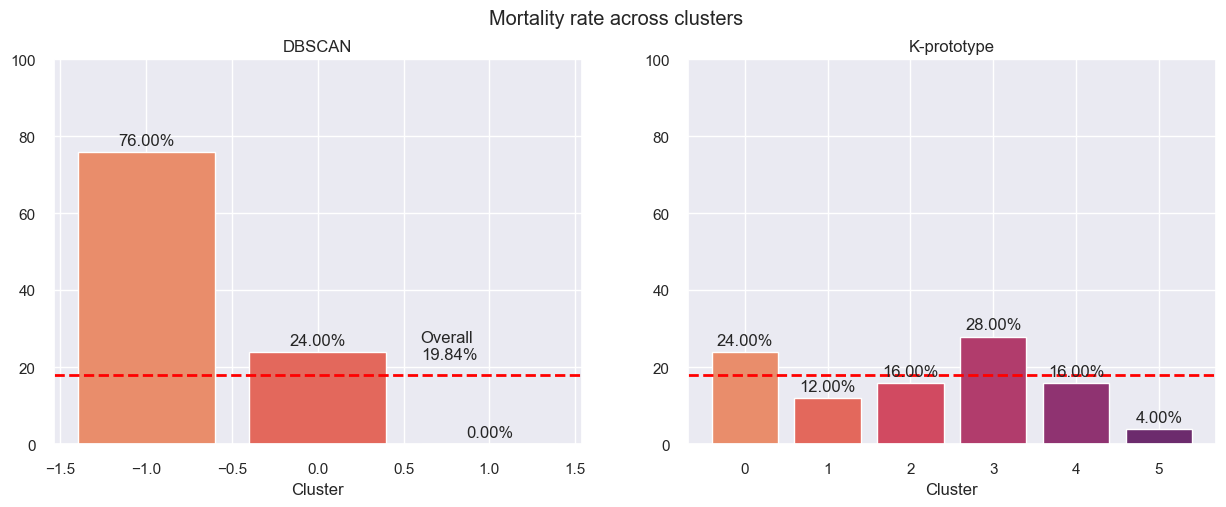

In [69]:
# Mortality rate in each cluster
plt.figure(figsize=(15,5))

# plt.subplot(1,3,1)
# plot_mortality('cluster')
# plt.ylabel("Mortality rate (%)")
# plt.title("K-means")

plt.subplot(1,2,1)
plot_mortality('DB_cluster')
plt.title("DBSCAN")
plt.annotate('Overall\n19.84%', xy=(0.6, 20), xytext=(0.6, 22))

plt.subplot(1,2,2)
plot_mortality('proto_cluster')
plt.title("K-prototype")

plt.suptitle("Mortality rate across clusters")

plt.show()

Text(0.5, 0.98, 'Data distribution based on clusters')

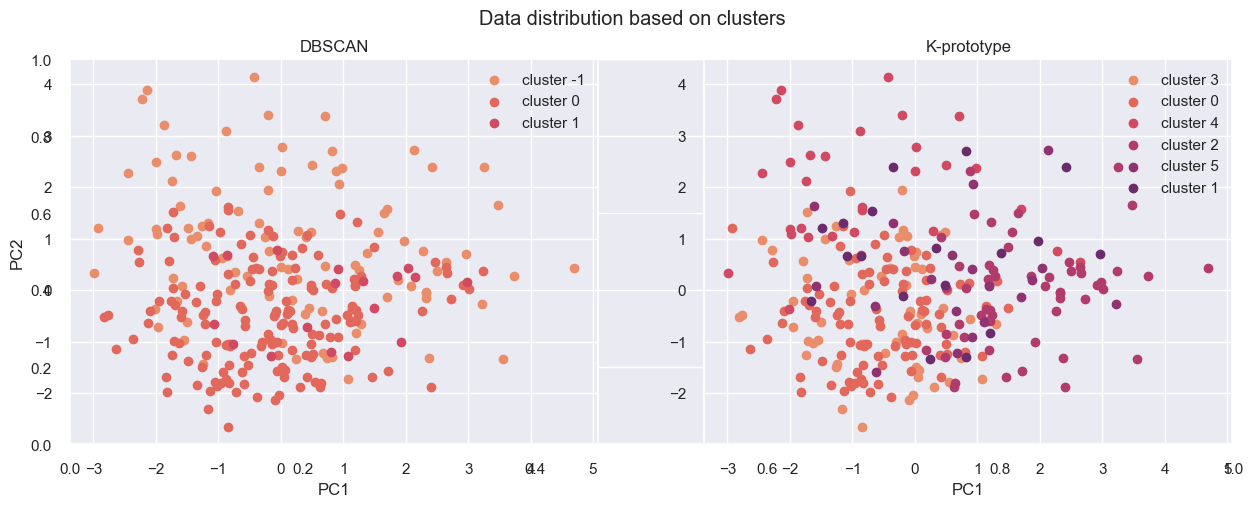

In [65]:
plt.figure(figsize=(15,5))

# plt.subplot(1,3,1)
# scatter_plot('cluster')

plt.ylabel('PC2')
# plt.title("K-means")
# plt.legend()

plt.subplot(1,2,1)
scatter_plot('DB_cluster')
plt.title("DBSCAN")
plt.legend()

plt.subplot(1,2,2)
scatter_plot('proto_cluster')
plt.title("K-prototype")
plt.legend()

plt.suptitle("Data distribution based on clusters")

In [66]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='cluster', title="K-means", color_discrete_sequence=palette)
fig.show()

In [67]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='DB_cluster', title="DBSCAN", color_discrete_sequence=palette)
fig.show()
fig.write_image("../output/pheno_DBSCAN_dist.png")

In [68]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='proto_cluster', title="K-prototype", color_discrete_sequence=palette)
fig.show()
fig.write_image("../output/pheno_Kprototype_dist.png")